In [22]:
import json
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn as nn

# === 加载数据 ===
with open("combined_data.json", "r") as f:
    data = json.load(f)

x_g = np.array(data["interpolated_data"]["g"])  # (N, T)
x_r = np.array(data["interpolated_data"]["r"])
mask_g = np.array(data["mask_data"]["g"])
mask_r = np.array(data["mask_data"]["r"])
labels = data["mergedType"]
label_map = {'Ia': 0, 'II': 1, 'Ibc': 1, 'Other': 1}
# label_map = {'Ia': 0, 'II': 1, 'Ibc': 2, 'Other': 3}
y = np.array([label_map[l] for l in labels])


In [23]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y)

# 计算类别权重（'balanced' = 1 / n_i）
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)

# 转换为 tensor 给 CrossEntropyLoss 用

class_weights = np.clip(weights, 0.5, 10.0)  # 最小1.0，最大5.0
class_weights = torch.tensor(class_weights, dtype=torch.float32)
# 转为torch tensor
print("Class weights:", class_weights)

Class weights: tensor([0.6540, 2.1229])


In [24]:
def masked_standardize(x, mask):
    obs = x[mask == 1]
    mean, std = obs.mean(), obs.std()
    x_std = np.zeros_like(x)
    x_std[mask == 1] = (x[mask == 1] - mean) / (std + 1e-8)
    return x_std

x_g_std = masked_standardize(x_g, mask_g)
x_r_std = masked_standardize(x_r, mask_r)

def crop_single(x, mask):
    idx = np.where(mask == 1)[0]
    if len(idx) == 0:
        return np.zeros((1, 1)), 1
    x_crop = x[idx[0]:idx[-1]+1].reshape(-1, 1)
    return x_crop, x_crop.shape[0]


In [25]:
class DualGRUDataset(Dataset):
    def __init__(self, xg_all, xr_all, mg_all, mr_all, y_all):
        self.Xg, self.Xr, self.Lg, self.Lr = [], [], [], []
        for i in range(len(xg_all)):
            g_crop, len_g = crop_single(xg_all[i], mg_all[i])
            r_crop, len_r = crop_single(xr_all[i], mr_all[i])
            self.Xg.append(torch.tensor(g_crop, dtype=torch.float32))
            self.Xr.append(torch.tensor(r_crop, dtype=torch.float32))
            self.Lg.append(len_g)
            self.Lr.append(len_r)
        self.y = torch.tensor(y_all, dtype=torch.long)

    def __len__(self): return len(self.y)

    def __getitem__(self, idx):
        return self.Xg[idx], self.Lg[idx], self.Xr[idx], self.Lr[idx], self.y[idx]

def collate_fn(batch):
    xg, lg, xr, lr, y = zip(*batch)
    xg_pad = pad_sequence(xg, batch_first=True)  # [B, T_g, 1]
    xr_pad = pad_sequence(xr, batch_first=True)  # [B, T_r, 1]
    return xg_pad, torch.tensor(lg), xr_pad, torch.tensor(lr), torch.tensor(y)


In [26]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class DualLSTMMultiHeadAttention(nn.Module):
    def __init__(self, hidden_dim=64, num_heads=3, num_classes=2):
        super().__init__()

        # g、r 通道使用独立 LSTM
        self.lstm_g = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.lstm_r = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)

        # 每个通道的多头注意力机制
        self.attn_heads_g = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(num_heads)
        ])
        self.attn_heads_r = nn.ModuleList([
            nn.Linear(hidden_dim, 1) for _ in range(num_heads)
        ])

        # 拼接后送入分类器
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2 * num_heads, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, xg, lg, xr, lr):
        # === g 通道 ===
        packed_g = pack_padded_sequence(xg, lg.cpu(), batch_first=True, enforce_sorted=False)
        out_g, (h_g, c_g) = self.lstm_g(packed_g)
        out_g, _ = pad_packed_sequence(out_g, batch_first=True)  # [B, T_g, H]

        # === r 通道 ===
        packed_r = pack_padded_sequence(xr, lr.cpu(), batch_first=True, enforce_sorted=False)
        out_r, (h_r, c_r) = self.lstm_r(packed_r)
        out_r, _ = pad_packed_sequence(out_r, batch_first=True)  # [B, T_r, H]

        def apply_multihead_attention(out, attn_heads):
            context_vectors = []
            for attn in attn_heads:
                scores = attn(out)                    # [B, T, 1]
                weights = torch.softmax(scores, dim=1)  # [B, T, 1]
                context = (out * weights).sum(dim=1)  # [B, H]
                context_vectors.append(context)
            return torch.cat(context_vectors, dim=1)  # [B, H * num_heads]

        context_g = apply_multihead_attention(out_g, self.attn_heads_g)
        context_r = apply_multihead_attention(out_r, self.attn_heads_r)

        # 拼接两个通道注意力输出
        context = torch.cat([context_g, context_r], dim=1)  # [B, 2H*num_heads]
        return self.classifier(context)  # [B, num_classes]


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

# === 划分数据集（GRU 输入）===
xg_train, xg_test, xr_train, xr_test, mg_train, mg_test, mr_train, mr_test, y_train, y_test = train_test_split(
    x_g_std, x_r_std, mask_g, mask_r, y, test_size=0.2, random_state=42, stratify=y
)

train_dataset = DualGRUDataset(xg_train, xr_train, mg_train, mr_train, y_train)
test_dataset = DualGRUDataset(xg_test, xr_test, mg_test, mr_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

# === 初始化模型 ===
model = DualLSTMMultiHeadAttention(hidden_dim=64, num_heads=3, num_classes=len(classes))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# === 开始训练 ===
num_epochs = 30
train_losses, test_losses = [], []
train_accs, test_accs = [], []
best_acc, best_state = 0, None

for epoch in range(num_epochs):
    model.train()
    correct, total, loss_sum = 0, 0, 0
    for xg, lg, xr, lr, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xg, lg, xr, lr)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        loss_sum += loss.item() * yb.size(0)

    train_accs.append(correct / total)
    train_losses.append(loss_sum / total)

    # === 测试 ===
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xg, lg, xr, lr, yb in test_loader:
            logits = model(xg, lg, xr, lr)
            loss = criterion(logits, yb)
            preds = torch.argmax(logits, dim=1)

            correct += (preds == yb).sum().item()
            total += yb.size(0)
            loss_sum += loss.item() * yb.size(0)

            all_preds.extend(preds.tolist())
            all_labels.extend(yb.tolist())

    test_acc = correct / total
    test_losses.append(loss_sum / total)
    test_accs.append(test_acc)

    if test_acc > best_acc:
        best_acc = test_acc
        best_state = model.state_dict()

# === 恢复最佳模型并评估 ===
model.load_state_dict(best_state)
model.eval()
all_preds, all_labels, all_prob = [], [], []
with torch.no_grad():
    for xg, lg, xr, lr, yb in test_loader:
        logits = model(xg, lg, xr, lr)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)
        all_preds.extend(preds.tolist())
        all_labels.extend(yb.tolist())
        all_prob.extend(probs.tolist())



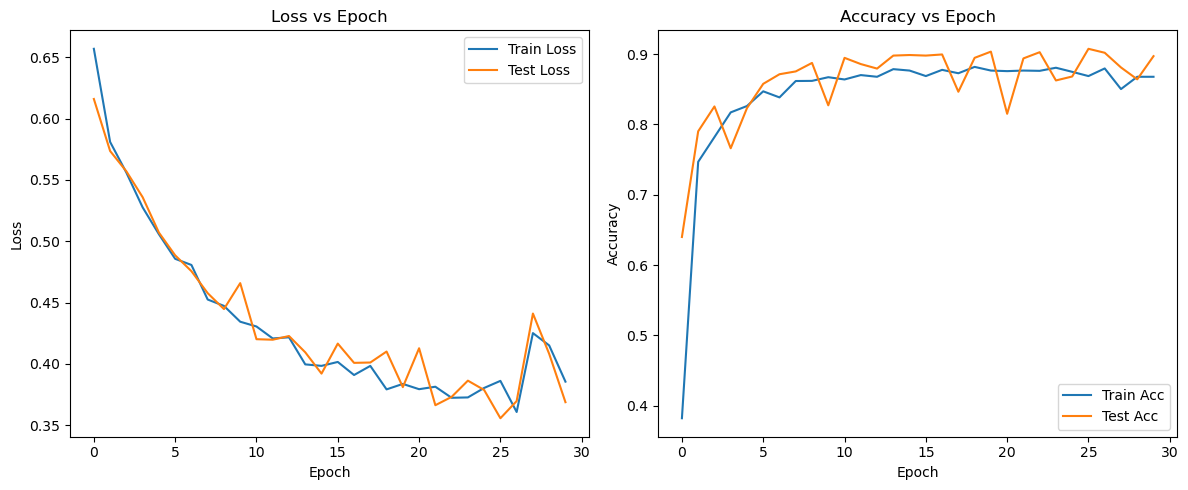

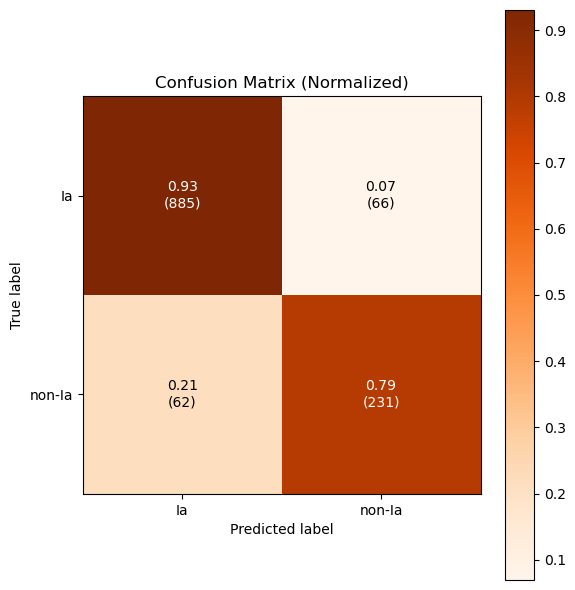

In [28]:
# === 绘图：loss & accuracy vs epoch ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(test_accs, label="Test Acc")
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

# === 混淆矩阵 ===
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# 可视化
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Oranges)
plt.colorbar(im, ax=ax)

# 设置标签
# classes = ['Ia', 'II', 'Ibc', 'Other']  # 自定义类别名称
classes = ['Ia', 'non-Ia']  # 自定义类别名称
ax.set(
    xticks=np.arange(len(classes)),
    yticks=np.arange(len(classes)),
    xticklabels=classes,
    yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (Normalized)'
)

# 显示数值 + 真实数量
thresh = cm_normalized.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm_normalized[i, j]
        count = cm[i, j]
        ax.text(j, i, f'{value:.2f}\n({count})',
                ha="center", va="center",
                color="white" if value > thresh else "black")

plt.tight_layout()
plt.show()



F1 Score: 0.7831
AUC Score: 0.9173


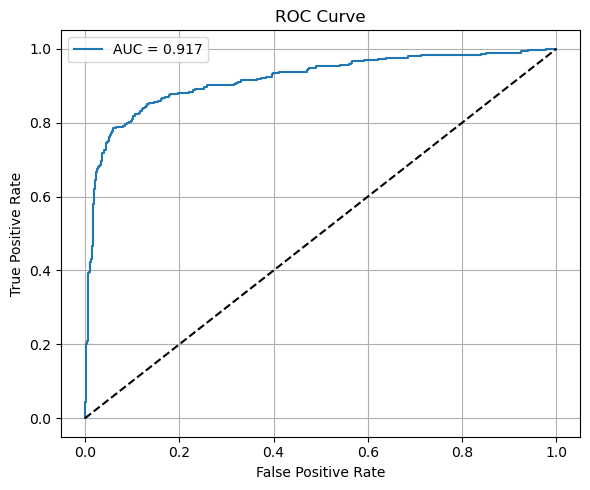

In [31]:
from sklearn.metrics import roc_curve, auc, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
# from scipy.special import softmax  # 若输出为logits则手动加

y_true = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_prob)
num_classes = y_prob.shape[1]

# 二分类则用 binary方式
if num_classes == 2:
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1])
    auc_val = auc(fpr, tpr)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nF1 Score: {f1:.4f}")
    print(f"AUC Score: {auc_val:.4f}")
    
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

else:
    # 多分类处理
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    f1 = f1_score(y_true, y_pred, average='macro')
    # auc_val = roc_auc_score(y_true_bin, y_prob, average='macro')
    auc_val = roc_auc_score(y_true_bin, y_prob, average='weighted')
    print(f"\nMacro F1 Score: {f1:.4f}")
    print(f"Weighted AUC Score: {auc_val:.4f}")

    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        auc_i = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {auc_i:.3f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves by Class")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [32]:
import numpy as np

def convert_to_json_serializable(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int64, np.int32, np.integer)):
        return int(obj)
    elif isinstance(obj, (np.float64, np.float32, np.floating)):
        return float(obj)
    elif isinstance(obj, dict):
        return {k: convert_to_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_json_serializable(v) for v in obj]
    else:
        return obj

Comb = {
    "all-labels": all_labels,
    "all-preds": all_preds,
    "all-probs": all_prob,
}

with open("two-class_lstm.json", "w") as f:
    json.dump(convert_to_json_serializable(Comb), f, indent=2)